In [1]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Set random seeds for reproducibility
SEED = 42  # You can choose any integer for reproducibility

# Set random seed for NumPy, Python, and TensorFlow
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Load the CSV file
csv_path = "/kaggle/input/dataset-csv/dataset_lung.xlsx"
data = pd.read_excel(csv_path)

data.head()

,Full_slice,Nodule,TumorClass
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4


In [2]:
def load_nrrd(file_path):
    """Load an NRRD file using SimpleITK."""

    train_loc = '/kaggle/input/test-dataset/Train'
    
    file_path = os.path.join(train_loc, file_path)
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
    return array

In [3]:
data_loaded = False
if not data_loaded:
    images = data['Full_slice']
    images = images.apply(load_nrrd)

    nodules = data['Nodule']
    nodules = nodules.apply(load_nrrd)

    labels = data['TumorClass']
    
    print(images[0].shape, nodules[0].shape)
    print(images[1].shape, nodules[1].shape)
    print(images[2].shape, nodules[2].shape)
    print(images[3].shape, nodules[3].shape)

    np.savez("new_dataset", images=images, labels=labels, nodules=nodules)
    
else:
    path = ''
    data = np.load(path)
    images = data['images']
    labels = data['labels']
    nodules = data['nodules']

(512, 512) (84, 92)
(512, 512) (90, 85)
(512, 512) (74, 76)
(512, 512) (85, 80)


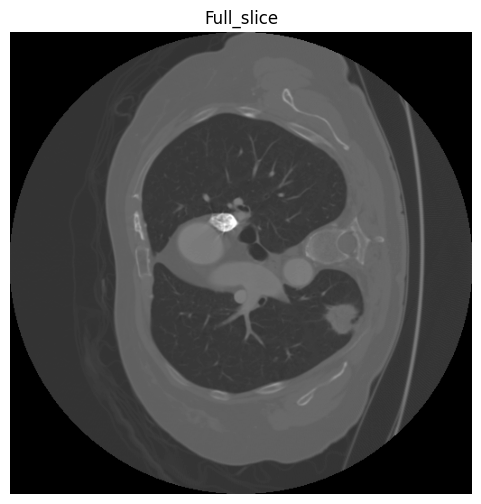

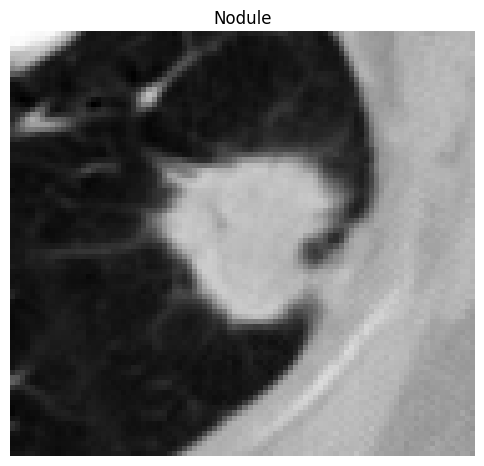

In [4]:
def visualize_image(image, title="Image"):
    """Visualize a 2D image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize full slice and nodule
visualize_image(images[0], title="Full_slice")
visualize_image(nodules[0], title="Nodule")

In [5]:
from skimage.feature import match_template

def locate_template(image, template):
    # Perform template matching
    result = match_template(image, template)
    
    # Find the location with the highest match score
    ij = np.unravel_index(np.argmax(result), result.shape)
    y, x = ij

    return x, y

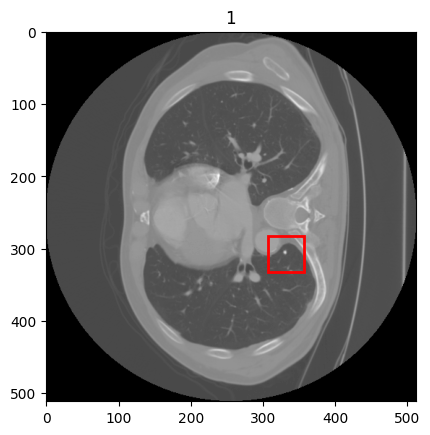

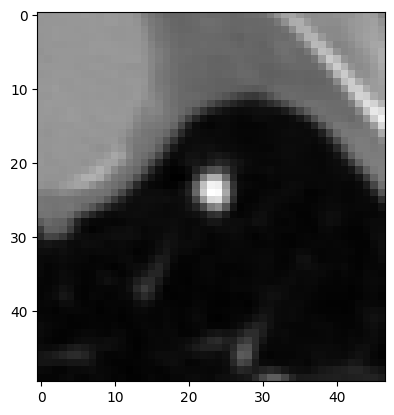

In [6]:
import matplotlib.patches as patches


x, y = locate_template(images[30], nodules[30])
fig, axis = plt.subplots()
plt.title(labels[30])
axis.imshow(images[30], cmap='gray')
r = patches.Rectangle((x, y), nodules[30].shape[0], nodules[30].shape[0], linewidth=2, edgecolor='r', facecolor='none')
axis.add_patch(r)
plt.figure()
plt.imshow(nodules[30], cmap='gray')

In [7]:
from collections import Counter
label_counts = Counter(labels)
print(label_counts)

Counter({3: 1092, 2: 457, 4: 418, 1: 244, 5: 152})


* Model 01 - classify Benign / Malignant on ROI

# **EDA Nodules Images**

we want to see the dimensions of nodules images to see if they are different

In [8]:
i = 0
for n in nodules[:20]:
    print(n.shape, labels[i])
    i += 1

(84, 92) 5
(90, 85) 5
(74, 76) 2
(85, 80) 5
(59, 53) 4
(59, 60) 4
(51, 51) 2
(50, 50) 3
(54, 54) 3
(51, 49) 2
(51, 51) 2
(50, 51) 3
(62, 62) 2
(57, 55) 3
(85, 93) 5
(67, 66) 5
(57, 50) 3
(52, 51) 3
(50, 49) 2
(48, 50) 2


converto le label in binario, faccio resizing e normalizzo e faccio lo stack per rendere le immagini rgb

Type of the image:  int16
Value range is:  [-991, 470]


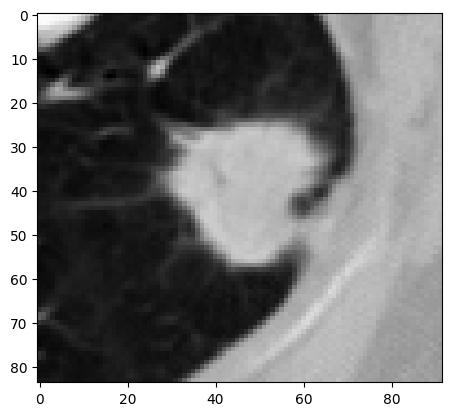

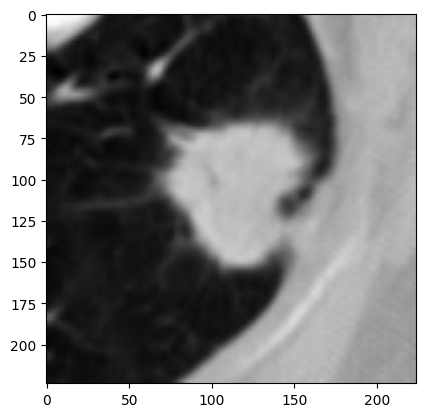

In [9]:
import cv2

new_shape = (224, 224)
print("Type of the image: ", nodules[0].dtype)
print("Value range is: ", [np.min(nodules[0]), np.max(nodules[0])])
# View original and resized image
plt.imshow(nodules[0], cmap="gray")
plt.figure()
plt.imshow(cv2.resize(nodules[0], new_shape), cmap="gray")

In [10]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf

# Class Definition
benign_classes = [1, 2, 3]
malign_classes = [4, 5]

# Function to convert labels to binary
def convert_to_binary_labels(labels, benign_classes, malign_classes):
    binary_labels = np.zeros(labels.shape[0], dtype=int)
    for i, label in enumerate(labels):
        if label in benign_classes:
            binary_labels[i] = 0
        else:
            binary_labels[i] = 1
    return binary_labels

# Converting labels to binary
labels_binary = convert_to_binary_labels(labels, benign_classes, malign_classes)

# Initial division into train, validation and test sets
X_d, X_test, y_d, y_test = train_test_split(nodules, labels_binary, test_size=0.2, stratify=labels_binary, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_d, y_d, test_size=0.1, stratify=y_d, random_state=SEED)

# Function to preprocess a dataset (resize, normalization with train-based Min-Max scaling)
def preprocess_dataset_min_max_scaling(X_train, X_valid, X_test, new_shape=(256, 256)):
    # Resize all images to ensure they have the same shape
    X_train_resized = np.array([cv2.resize(img, new_shape, interpolation=cv2.INTER_CUBIC) for img in X_train])
    X_valid_resized = np.array([cv2.resize(img, new_shape, interpolation=cv2.INTER_CUBIC) for img in X_valid])
    X_test_resized = np.array([cv2.resize(img, new_shape, interpolation=cv2.INTER_CUBIC) for img in X_test])

    # Calculate the minimums and maximums on the training set
    min_val = np.min(X_train_resized)
    max_val = np.max(X_train_resized)

    # Normalization function based on min and max of the train set
    def scale_images(X):
        return (X - min_val) / (max_val - min_val)  # Normalization between 0 and 1
    
    # Image normalization in the training, validation and test set
    X_train_scaled = scale_images(X_train_resized)
    X_valid_scaled = scale_images(X_valid_resized)
    X_test_scaled = scale_images(X_test_resized)

    # After scaling to [0, 1], now scale to [0, 255]
    X_train_scaled_255 = 255 * X_train_scaled
    X_valid_scaled_255 = 255 * X_valid_scaled
    X_test_scaled_255 = 255 * X_test_scaled

    # Convert to RGB format by replicating channels
    X_train_rgb = np.stack((X_train_scaled_255, X_train_scaled_255, X_train_scaled_255), axis=-1)
    X_valid_rgb = np.stack((X_valid_scaled_255, X_valid_scaled_255, X_valid_scaled_255), axis=-1)
    X_test_rgb = np.stack((X_test_scaled_255, X_test_scaled_255, X_test_scaled_255), axis=-1)

    return X_train_rgb, X_valid_rgb, X_test_rgb

# Dataset preprocessing
new_shape = (256, 256)
X_train_rgb, X_valid_rgb, X_test_rgb = preprocess_dataset_min_max_scaling(X_train, X_valid, X_test, new_shape=new_shape)

# Checking the final shapes
print("X_train shape:", X_train_rgb.shape)
print("X_valid shape:", X_valid_rgb.shape)
print("X_test shape:", X_test_rgb.shape)

# Checking the shapes
print("y_train_binary shape:", y_train.shape)
print("y_valid_binary shape:", y_valid.shape)
print("y_test_binary shape:", y_test.shape)


X_train shape: (1701, 256, 256, 3)
X_valid shape: (189, 256, 256, 3)
X_test shape: (473, 256, 256, 3)
y_train_binary shape: (1701,)
y_valid_binary shape: (189,)
y_test_binary shape: (473,)


In [ ]:
# Check the minimum and maximum for each channel in the normalized images
print("Min and Max values of X_train_rgb (R channel):", np.min(X_train_rgb[:, :, :, 0]), np.max(X_train_rgb[:, :, :, 0]))
print("Min and Max values of X_train_rgb (G channel):", np.min(X_train_rgb[:, :, :, 1]), np.max(X_train_rgb[:, :, :, 1]))
print("Min and Max values of X_train_rgb (B channel):", np.min(X_train_rgb[:, :, :, 2]), np.max(X_train_rgb[:, :, :, 2]))

# Global check on normalized data
print("Min and Max values of X_train_rgb:", np.min(X_train_rgb), np.max(X_train_rgb))

In [ ]:
plt.imshow(X_train_rgb[0, :, :, 0], cmap='gray')
plt.colorbar()

Now we can see the class distribution

In [ ]:
classes_names_bin, counts_bin = np.unique(y_train, return_counts=True)

print(classes_names_bin, counts_bin)

#for plotting we can use plt.bar function for example
plt.bar(x=classes_names_bin,height=counts_bin, facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Checking classes before SMOTE
classes_names_bin, counts_bin = np.unique(y_train, return_counts=True)
print("Class distribution before SMOTE:", dict(zip(classes_names_bin, counts_bin)))

# Calculating class weights before SMOTE
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights (before SMOTE):", class_weights_dict)

the dataset is highly unbalanced, we can balance it using SMOTE, oversampling e weight classes

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Checking classes before SMOTE
classes_names_bin, counts_bin = np.unique(y_train, return_counts=True)
print("Class distribution before SMOTE:", dict(zip(classes_names_bin, counts_bin)))

# Calculating class weights before SMOTE
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights (before SMOTE):", class_weights_dict)

# Initializing SMOTE

smote = SMOTE(random_state=SEED)

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_rgb.reshape(X_train_rgb.shape[0], -1),  # SMOTE requires a 2D array
    y_train
)

# Reshape X_train_resampled to image format (RGB)
X_train_resampled = X_train_resampled.reshape(-1, X_train_rgb.shape[1], X_train_rgb.shape[2], 3)

# Checking classes after SMOTE
classes_names_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(classes_names_resampled, counts_resampled)))

# View class distribution
plt.bar(x=classes_names_resampled, height=counts_resampled, facecolor='#85c1e9')
plt.title("Classes Occurrence After SMOTE", color="black")
plt.xlabel("Classes", color="black")
plt.ylabel("Occurrences", color="black")
plt.xticks(rotation=90)
plt.show()

# Print the class weights calculated before SMOTE again
print("Class Weights (for use during training):", class_weights_dict)

voglio visualizzare un esempio, prima vedo il range

In [ ]:
print("Min value:", X_train_resampled[10].min())
print("Max value:", X_train_resampled[10].max())

per visualizzare ma non dover convertire in uint8 ho deciso di usare un solo canale

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    # Normalization: scales values ​​between 0 and 255
    ax.imshow(X_train_resampled[i, :, :, 1] , cmap='gray', vmin=0, vmax=255)  # Use only one channel
    ax.set_title(f"Label: {y_train_resampled[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0

X_train=X_train_resampled
X_valid=X_valid_rgb
X_test=X_test_rgb
y_train= y_train_resampled


train_data_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=360, 
    width_shift_range=0.2,  # Increase shift range
    height_shift_range=0.2,
    shear_range=0.2,  # Increase transformation intensity
    zoom_range=(0.7, 1.3),  # More zoom variability
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.6, 1.4),  # Stronger brightness augmentation
    fill_mode='nearest',
)


val_data_generator = ImageDataGenerator(rescale=1/255)
test_data_generator = ImageDataGenerator(rescale=1/255)


train_data_generator.fit(X_train)
val_data_generator.fit(X_valid)
test_data_generator.fit(X_test)

# Batch generation
batch_size = 16
train_generator = train_data_generator.flow(
    x=X_train, y=y_train,
    batch_size=batch_size,
    shuffle=True,
    seed=SEED
)

val_generator = val_data_generator.flow(
    x=X_valid, y=y_valid,
    batch_size=batch_size,
    shuffle=True,
    seed=SEED 
)

test_generator = val_data_generator.flow(
    x=X_test, y=y_test,
    batch_size=16,
    shuffle = True,
    seed=SEED
)

# Weight file path

model_directory='/kaggle/input/efficientnetv2s/keras/default/1/efficientnetv2-s_notop.h5'
efficientnetv2s = EfficientNetV2S(weights=model_directory, input_shape=(256, 256, 3), include_top=False)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# freeze all layers
efficientnetv2s.trainable = True
for layer in efficientnetv2s.layers[:-10]: 
    layer.trainable = True


    
# Model construction
inputs = tf.keras.Input(shape=(256, 256, 3), name='input_layer')
#x = preprocess_input(inputs)  # Preprocessing with ImageNet
x = efficientnetv2s(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(128, activation='relu', name='dense1')(x)
x = tfkl.Dropout(0.5, name='dropout3')(x)
x = tfkl.BatchNormalization(name='batchnorm1')(x)

# Output Layer - sigmoid binary classification
outputs = tfkl.Dense(1, name='dense2')(x)


# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Ottimizzatore Adam con learning rate basso
adam_optimizer = Adam(learning_rate=1e-5)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Corrected to use tf.keras
    optimizer=adam_optimizer,
    metrics=['accuracy', 'AUC']
)
# Model Summary
model.summary()

# View the model architecture
plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Training with generators and class weights
batch_size = 16
history = model.fit(
    train_generator,
    batch_size=16,
    epochs=100,
    validation_data=(X_valid/255 , y_valid),
    class_weight=class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)
    ],
    verbose=1
)

# Final Validation Accuracy
final_val_accuracy = round(max(history.history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test/255, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")


In [ ]:
print(1 - y_test.sum() / y_test.shape[0])

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test/255).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_keras, tpr_keras)

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2  # Line width
plt.plot(fpr_keras, tpr_keras, color="darkorange", lw=lw, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")  # Reference diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, tfk.activations.sigmoid(y_pred) >= 0.5)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('/kaggle/working/model_final.h5')

In [ ]:
import os
print(os.listdir("/kaggle/working/"))

## RELOADING THE BEST MODEL

In [11]:
from tensorflow.keras.models import load_model

# Load the best model
#best_model = load_model('/kaggle/working/model_besta.h5')  # If saved in working directory
best_model = load_model('/kaggle/input/model_final/keras/default/1/model_final.h5')  # If saved in outputs

best_model.trainable=False
best_model.get_layer('dropout3').trainable= True

# Check the model summary to verify it's loaded
best_model.summary()



Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 8, 8, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm1 (BatchNormalization) │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,495,971 (78.19 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,495,969 (78.19 MB)

 Optimizer params: 2 (12.00 B)

## MONTE CARLO DROPOUT

In [12]:
import numpy as np
import tensorflow.keras as keras
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

def compute_metric_ci_interval(metric):
    """
    Compute mean, standard deviation, and 95% confidence interval for a given metric.
    """
    mean_metric = np.mean(metric, axis=0)
    std_metric = np.std(metric, axis=0)
    ci_lower = mean_metric - 1.96 * std_metric
    ci_upper = mean_metric + 1.96 * std_metric
    
    return mean_metric, ci_lower, ci_upper, std_metric

def compute_metrics(probs, labels):
    """
    Computes accuracy, F1-score, precision, recall, AUC, and confusion matrix metrics for binary classification.
    """
    preds = (probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')  # Binary F1-score
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    
    # Compute AUC for binary classification
    auc_score = roc_auc_score(labels, probs)
    
    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    tn = cm[0, 0]
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    return accuracy, f1, precision, recall, auc_score, tpr, fpr, tnr, fnr 


def monte_carlo_simulation(model, X_test, y_test, n_simulations=50):
    """
    Performs Monte Carlo Dropout-based uncertainty estimation for binary classification.
    """
    
    test_probs = []
    test_preds = [] 
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []
    test_auc = []
    test_fpr = []
    test_tpr = []
    test_tnr = []
    test_fnr = []

    #  Corrected indentation here
    for i in range(n_simulations):
        logits = model.predict(X_test)  # Ensure correct scaling
        probs = keras.activations.sigmoid(logits).numpy()  # Apply sigmoid for binary classification
        preds = probs >= 0.5

        test_probs.append(probs)
        test_preds.append(preds)
        
        accuracy, f1, precision, recall, auc_score, tpr, fpr, tnr, fnr = compute_metrics(probs, y_test)
        
        test_acc.append(accuracy)
        test_f1.append(f1)
        test_precision.append(precision)
        test_recall.append(recall)
        test_auc.append(auc_score)
        test_fpr.append(fpr)
        test_tpr.append(tpr)
        test_tnr.append(tnr)
        test_fnr.append(fnr)
    
    return test_probs, test_preds, (test_acc, test_f1, test_precision, test_recall, test_auc, test_fpr, test_tpr, test_tnr, test_fnr)


In [13]:
import numpy as np
import tensorflow as tf


# Crea un modello MC che forza il dropout durante la previsione
class MCModel(tf.keras.Model):
    def call(self, inputs, training=True):  # Assicura che sia in modalità training
        return super().call(inputs, training=True)

# Crea un modello MC basato sul tuo modello esistente
mc_model2 = MCModel(inputs=best_model.input, outputs=best_model.output)

# Assicurati che X_test_rgb sia scalato correttamente
X_test_rgb = X_test_rgb / 255.0

# Esegui la previsione
test_probs, test_preds, test_metrics = monte_carlo_simulation(mc_model2, X_test_rgb, y_test, n_simulations=50)

# Calcola gli intervalli di confidenza
acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[0])
print(f"Accuracy: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[1])
print(f"F1: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[2])
print(f"Precision: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[3])
print(f"Recall: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[4])
print(f"AUC: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

I0000 00:00:1738775123.371933      69 service.cc:145] XLA service 0x7e5d8c021c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738775123.371987      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step  

I0000 00:00:1738775179.231838      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


Accuracy: 0.72 (95% CI: 0.69, 0.75) - STD: 0.02
F1-score: 0.52 (95% CI: 0.47, 0.57) - STD: 0.03
Precision: 0.45 (95% CI: 0.40, 0.49) - STD: 0.02
Recall: 0.63 (95% CI: 0.55, 0.70) - STD: 0.04
AUC: 0.75 (95% CI: 0.72, 0.79) - STD: 0.02
FPR: 0.25 (95% CI: 0.21, 0.28) - STD: 0.02
TPR: 0.63 (95% CI: 0.55, 0.70) - STD: 0.04
TNR: 0.75 (95% CI: 0.72, 0.79) - STD: 0.02
FNR: 0.37 (95% CI: 0.30, 0.45) - STD: 0.04


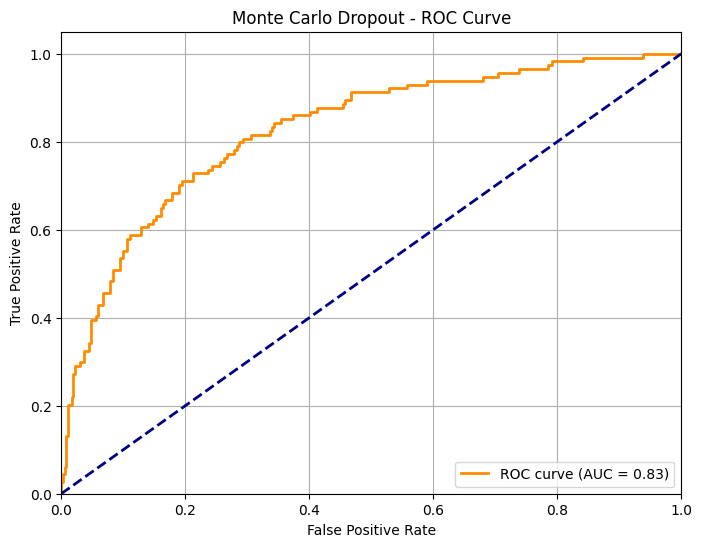

In [19]:
# ---- Compute confidence intervals ----
from sklearn.metrics import roc_curve, auc

metric_names = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'AUC', 'FPR', 'TPR', 'TNR', 'FNR']

# 'test_metrics' contains the lists of metric values from Monte Carlo simulation
metrics = test_metrics  # This should be a tuple of metrics (test_acc, test_f1, etc.)

# Compute confidence intervals
for i, metric in enumerate(metrics):
    mean_metric, ci_lower, ci_upper, std = compute_metric_ci_interval(metric)
    print(f"{metric_names[i]}: {mean_metric:.2f} (95% CI: {ci_lower:.2f}, {ci_upper:.2f}) - STD: {std:.2f}")

# ---- Plot ROC Curve ----
# Ensure you are using mean probabilities for plotting
fpr_vals, tpr_vals, _ = roc_curve(y_test, np.mean(test_probs, axis=0))
roc_auc = auc(fpr_vals, tpr_vals)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_vals, tpr_vals, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Monte Carlo Dropout - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()